making a network request
done making network call


TypeError: a bytes-like object is required, not 'str'

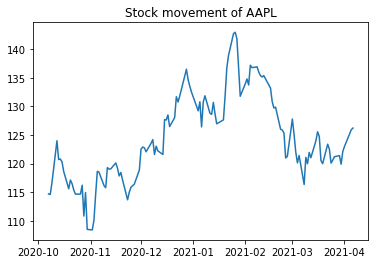

In [4]:
import csv
import random
import math
import operator

import pandas_datareader.data as web
import datetime
import pandas as pd

import matplotlib.pyplot as plt   # Import matplotlib
import json

# split the data into a trainingdataset and testdataset in ratio of 67/33

def loadDataset(filename, split, trainingSet=[], testSet=[], content_header=[]):
    with open(filename, 'r') as csvfile:
        # returns a reader object which will iterate over lines
        lines = csv.reader(csvfile)
        # dataset is a list of all data, where each item is a line as list
        dataset = list(lines)
        # minus 1 because we are predicting for next day
        for x in range(len(dataset) - 1):
            # convert the content to float
            # minus 1 because last is string for up or down
            for y in range(1, len(content_header) - 1):
                dataset[x][y] = float(dataset[x][y])
            if random.random() < split:
                trainingSet.append(dataset[x])
            else:
                testSet.append(dataset[x])



def euclideanDistance(instance1, instance2, length):
    distance = 0
    for x in range(1, length):
        distance += pow((instance1[x] - instance2[x]), 2)
    return math.sqrt(distance)


# get k nearest neighbors of the <array><num> testInstance among <array><array>
# trainingSet
def getNeighbors(trainingSet, testInstance, k):
    distance = []
    # minus 1 because we are splitting our data and test also has known class
    length = len(testInstance) - 1

    for x in range((len(trainingSet))):
        dist = euclideanDistance(testInstance, trainingSet[x], length)
        distance.append((trainingSet[x], dist))
    # sort based on the the item at index 1 i.e the distance
    distance.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distance[x][0])
    return neighbors


# make all responses vote their classification, the one with the highest vote
# wins
def getResponse(neighbors):
    classVotes = {}
    for x in range(len(neighbors)):
        response = neighbors[x][-1]
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    sortedVotes = sorted(classVotes.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]


def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    return (correct/float(len(testSet))) * 100.0


def getAccuracy1(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if RMSD(testSet[x][-1], predictions[x]) < 1:
            correct += 1
    return (correct/float(len(testSet))) * 100.0


def RMSD(X, Y):
    return math.sqrt(pow(Y - X, 2))


def change(today, yest):
    if today > yest:
        return 'up'
    return 'down'



def getData(filename, stockname, startdate, enddate):
    stock = web.DataReader(stockname, 'yahoo', startdate, enddate)
    print("done making network call")
    ass = [stock.index]
    stck_json = stock.to_json(orient="index", date_format='iso')
    stck_dates = json.loads(stck_json)

    plt.plot(stock["Adj Close"])
    plt.title("Stock movement of " + stockname)

    first_time = True
    with open(filename, 'wb') as pp:
        stockwriter = csv.writer(pp)
        stp = sorted(stck_dates.keys())
        for i in stp:
            new_format_date = i[:10]
            if first_time:
                first_time = False
                prev_closing = stck_dates[i]["Adj Close"]
                continue
            stockwriter.writerow([new_format_date] + [stck_dates[i]["Open"]] +  [stck_dates[i]["High"]] + [stck_dates[i]["Low"]]  +  [stck_dates[i]["Adj Close"]] + [change(stck_dates[i]["Adj Close"], prev_closing)])
            prev_closing = stck_dates[i]["Adj Close"]


def abc(filename, stockname, startdate, enddate):
    apple = web.DataReader(stockname, 'yahoo', startdate, enddate)
    with open(filename, 'wb') as csvfile:
        stockwriter = csv.writer(csvfile, quotechar=',')
        for ind in range(1, len(apple.Open)):
            stockwriter.writerow(["open: "] + [apple.Open[ind - 1]] + ["    high: "] + [apple.High[ind - 1]] + ["   low: "] + [apple.Low[ind - 1]] + ["  yester close: "] + [apple['Adj Close'][ind - 1]] + [" volume: "] + [apple.Volume[ind - 1]] + [change(apple['Adj Close'][ind], apple['Adj Close'][ind - 1])])



def predictFor(k, filename, stockname, startdate, enddate, writeAgain, split):
    iv = ["date", "open", "high", "low", "yesterday closing adj", "state change"]
    trainingSet = []
    testSet = []
    totalCount = 0

    if writeAgain:
        print("making a network request")
        getData(filename, stockname, startdate, enddate)

    # open the file
    loadDataset(filename, split, trainingSet, testSet, iv)

    print("Predicting for ", stockname)
    print("Train: " + repr(len(trainingSet)))
    print("Test: " + repr(len(testSet)))
    totalCount += len(trainingSet) + len(testSet)
    print("Total: " + repr(totalCount))

    # generate predictions
    predict_and_get_accuracy(testSet, trainingSet, k, stockname)


def predict_and_get_accuracy(testSet, trainingSet, k, stockname):
    predictions = []
    for x in range(len(testSet)):
        neighbors = getNeighbors(trainingSet, testSet[x], k)
        result = getResponse(neighbors)
        predictions.append(result)

    accuracy = getAccuracy(testSet, predictions)
    print('Accuracy: ' + repr(accuracy) + '%')

    # drawing another
    plt.figure(2)
    plt.title("Prediction vs Actual Trend of " + stockname)
    plt.legend(loc="best")
    row = []
    col = []
    for dates in range(len(testSet)):
        new_date = datetime.datetime.strptime(testSet[dates][0], "%Y-%M-%d")
        row.append(new_date)
        if predictions[dates]== "down":
            col.append(-1)
        else:
            col.append(1)
    predicted_plt, = plt.plot(row, col, 'r', label="Predicted Trend")

    row = []
    col = []
    for dates in range(len(testSet)):
        new_date = datetime.datetime.strptime(testSet[dates][0], "%Y-%M-%d")
        row.append(new_date)
        if testSet[dates][-1]== "down":
            col.append(-1)
        else:
            col.append(1)
    actual_plt, = plt.plot(row, col, 'b', label="Actual Trend")

    plt.legend(handles=[predicted_plt, actual_plt])


    plt.show()


def main():
    split = 0.67
    # set data
    startdate = datetime.datetime(2020,10,7)
    enddate = datetime.date.today()

    predictFor(4, 'aapl.csv', 'AAPL', startdate, enddate, 1, split)
    predictFor(4, 'amzn.csv', 'AMZN', startdate, enddate, 1, split)
    predictFor(4, 'tsla.csv', 'TSLA', startdate, enddate, 1, split)
    predictFor(4, 'nflx.csv', 'NFLX', startdate, enddate, 1, split)

main()
